# Support vector machine 

Les machines à vecteurs de support (SVM) constituent une classe particulièrement puissante et flexible d'algorithmes supervisés pour la classification et la régression. Ils sont particulièrement bien adaptés à la classification de jeux de données complexes, de tailles réduite ou moyenne.

Auteur: G. Sainton



In [1]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background') # 'pip install SciencePlots' if it doesn't work 
from scipy import stats


## Positionnement du problème

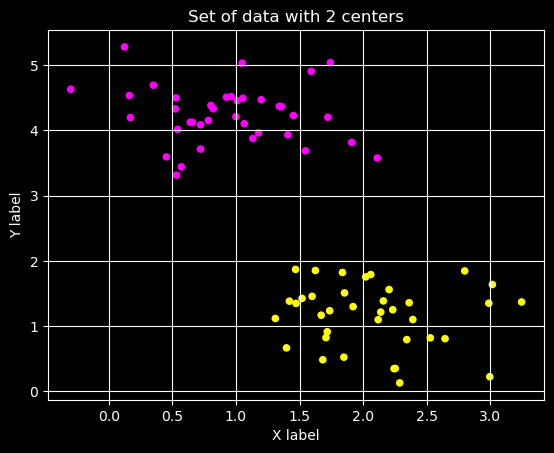

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=75, centers=2,
                  random_state=0, cluster_std=0.50)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='spring');
plt.grid(True)
plt.title("Set of data with 2 centers")
plt.xlabel("X label")
plt.ylabel("Y label")
plt.show()

Si les deux classes du plot ci-dessus peuvent être séparés par une droite, on dit qu'ils sont linéairement séparables. 
On peut faire quelques essais avec des droites...

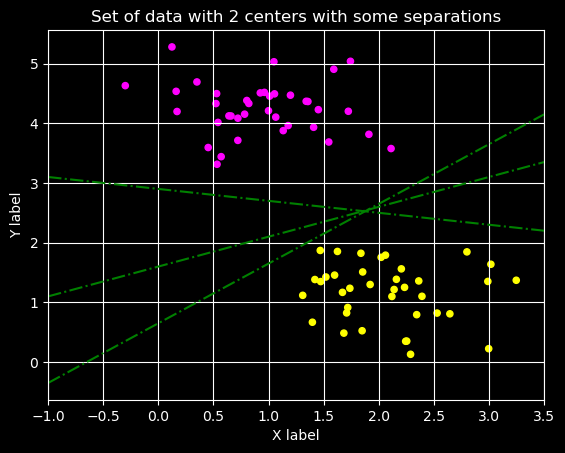

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='spring')
#plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-.g')
plt.title("Set of data with 2 centers with some separations")
plt.grid(True)
plt.xlabel("X label")
plt.ylabel("Y label")
plt.xlim(-1, 3.5);

Les machines à vecteurs de support offrent un moyen d'améliorer cette situation. 

L'intuition est la suivante : plutôt que de simplement tracer une ligne de largeur nulle entre les classes, nous pouvons tracer autour de chaque ligne une marge d'une certaine largeur, jusqu'au point le plus proche.

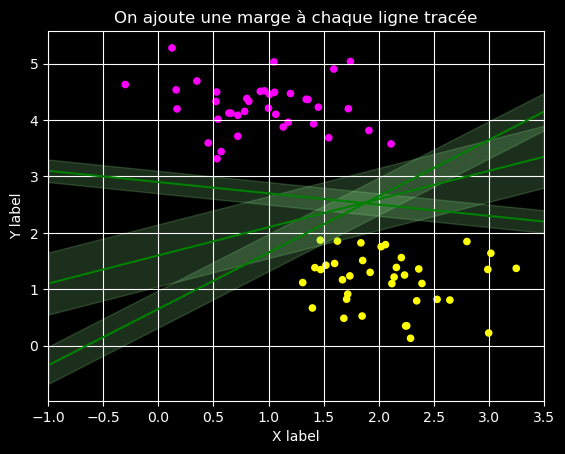

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='spring')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-g')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='lightgreen', alpha=0.2)
    
plt.title("On ajoute une marge à chaque ligne tracée")
plt.grid(True)
plt.xlabel("X label")
plt.ylabel("Y label")
plt.xlim(-1, 3.5);

Le principe du SVM est que la ligne qui maximise cette marge est celle que nous choisirons comme modèle optimal.

## Implementation avec Scikit learn


- C : Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.

- kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’ | Specifies the kernel type to be used in the algorithm. If none is given, ‘rbf’ will be used. If a callable is given it is used to pre-compute the kernel matrix from data matrices

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

In [6]:
print(model.support_vectors_[:, 0])
print(model.support_vectors_[:, 1])

[2.11114739 0.5323772  1.46870582]
[3.57660449 3.31338909 1.86947425]


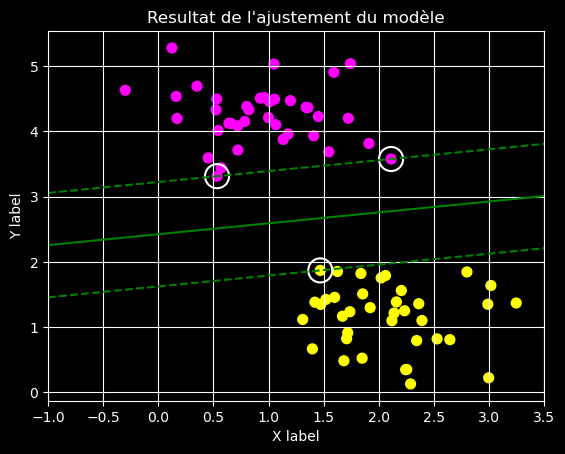

In [7]:
def plot_svc_decision(model, ax=None, plot_support=True):
    """
    
    Plot the decision function for a 2D SVC
    
    """
    
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='g',
               levels=[-1, 0, 1,],
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1.5, edgecolors='white',
                   facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plt.grid(True)
plt.xlabel("X label")
plt.ylabel("Y label")
plt.title("Resultat de l'ajustement du modèle")
plt.xlim(-1, 3.5);

plot_svc_decision(model)

Il s'agit de la ligne de démarcation qui maximise la marge entre les deux ensembles de points
Remarquez que certains des points d'entraînement touchent juste la marge : ils sont encerclés dans la figure suivante.
Ces points sont les éléments pivots de cet ajustement ; ils sont connus sous le nom de *vecteurs de support*, et donnent son nom à l'algorithme.
Dans Scikit-Learn, l'identité de ces points est stockée dans l'attribut `support_vectors_` du classificateur :

In [8]:
model.support_vectors_

array([[2.11114739, 3.57660449],
       [0.5323772 , 3.31338909],
       [1.46870582, 1.86947425]])

L'une des clés du succès de ce classificateur réside dans le fait que, pour l'ajustement, seules les positions des vecteurs de support comptent ; tout point situé plus loin de la marge mais du bon côté ne modifie pas l'ajustement. Techniquement, cela s'explique par le fait que ces points ne contribuent pas à la fonction de perte utilisée pour ajuster le modèle, de sorte que leur position et leur nombre n'ont pas d'importance tant qu'ils ne franchissent pas la marge.

In [9]:
def plot_svm(N=10, ax=None):
    """
    Function to plot SVM contours
    
    """
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    ax.grid(True)
    plot_svc_decision(model, ax)
    

In [10]:
from ipywidgets import interact, fixed
interact(plot_svm, N=(10, 200), ax=fixed(None));

interactive(children=(IntSlider(value=10, description='N', max=200, min=10), Output()), _dom_classes=('widget-…

## Test avec un cas non lineaire

On va cette fois générer des données circulaires et tester notre modèle de SVM que nous avons utilisé avant. C'est une modèle avec un noyau `linear`. 


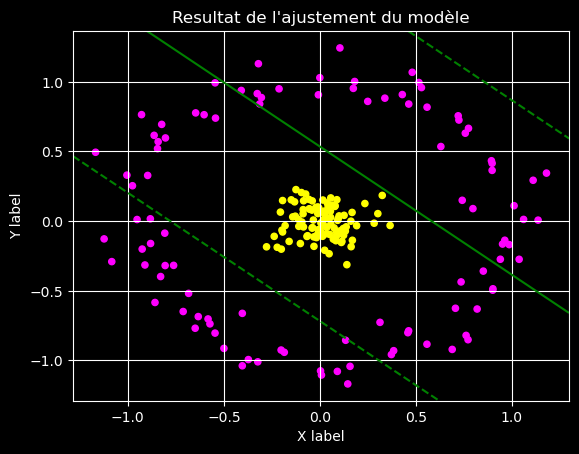

In [11]:
from sklearn.datasets import make_circles

X, y = make_circles(200, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='spring')
plt.grid(True)
plt.xlabel("X label")
plt.ylabel("Y label")
plt.title("Resultat de l'ajustement du modèle")
plot_svc_decision(clf, plot_support=False);

Le résultat n'est pas particulièrement étonnant, il est très loin de nos attentes. 
On peut alors modifier le noyau et mettre 'rbf' (Radial Basis Function) ou noyau gaussien

In [12]:
r = np.exp(-(X ** 2).sum(1))

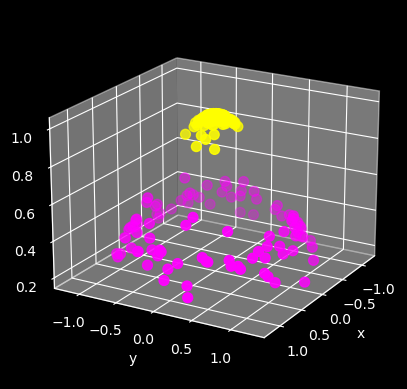

In [13]:
from mpl_toolkits import mplot3d

ax = plt.subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='spring')
ax.view_init(elev=20, azim=30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('r');

In [14]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

Text(0.5, 1.0, "Resultat de l'ajustement avec un noyau gaussien")

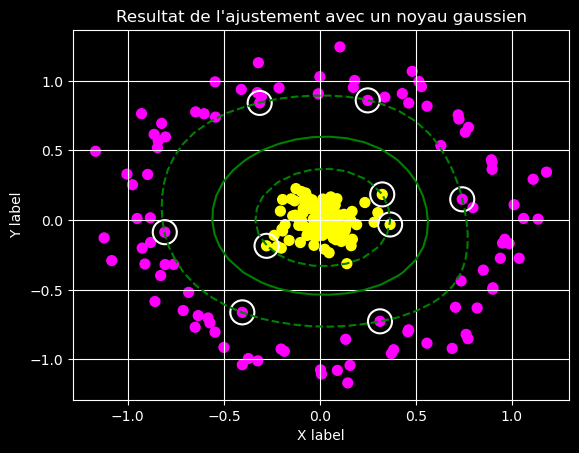

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')

plot_svc_decision(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');
plt.grid(True)
plt.xlabel("X label")
plt.ylabel("Y label")
plt.title("Resultat de l'ajustement avec un noyau gaussien")

## Classification à marge souple

Si nous imposons sctrictement que toutes les observations soient en dehors du chemin et du bon côté, nous effectuons une classification à marge rigide (*hard margin classification*).

- Ne fonctionne pas si les données ne sont pas linéairement séparables
- Sensible aux données abérrantes

Regardons ce qui se passe par exemple avec le dataset IRIS


In [16]:
from sklearn import datasets
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
iris = datasets.load_iris()

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=1e6)
svm_clf.fit(X, y)

SVC(C=1000000.0, kernel='linear')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


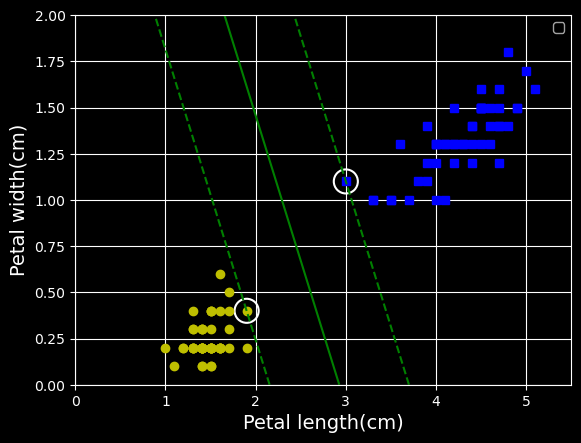

In [17]:
plt.grid(True)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length(cm)", fontsize=14)
plt.ylabel("Petal width(cm)", fontsize=14)
plt.legend()
plt.axis([0, 5.5, 0, 2])
plot_svc_decision(svm_clf)

Imaginons maintenant que j'ajoute des outliers dans les données 


In [18]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

Text(0.5, 1.0, 'Classification avec un facteur C = 1e9')

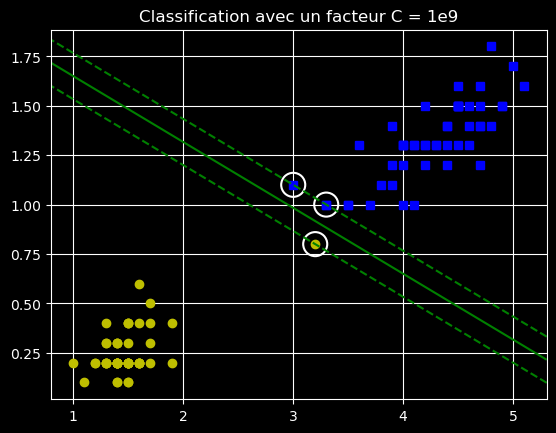

In [19]:
svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision(svm_clf2)
plt.grid(True)
plt.title("Classification avec un facteur C = 1e9")

In [20]:
def plot_svm_C(C=10, ax=None):
    iris = datasets.load_iris()

    iris = datasets.load_iris()
    X = iris["data"][:, (2, 3)]  # petal length, petal width
    y = iris["target"]

    setosa_or_versicolor = (y == 0) | (y == 1)
    X = X[setosa_or_versicolor]
    y = y[setosa_or_versicolor]
    
    X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
    y_outliers = np.array([0, 0])
    Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
    yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
    Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
    yo2 = np.concatenate([y, y_outliers[1:]], axis=0)
    
    svm_clf2 = SVC(kernel="linear", C=C)
    svm_clf2.fit(Xo2, yo2)
    
    ax = ax or plt.gca()
    ax.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
    ax.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
    ax.grid(True)
    plot_svc_decision(svm_clf2, ax)

In [21]:
from ipywidgets import interact, fixed, FloatSlider
#interact(plot_svm_C, C=(1, 200), ax=fixed(None));
interact(plot_svm_C, C=FloatSlider(min=0.1, max=1e3, step=2), ax=fixed(None));


interactive(children=(FloatSlider(value=0.1, description='C', max=1000.0, min=0.1, step=2.0), Output()), _dom_…

## Jouons avec le dataset MNIST

Je reprends ici un énoncé de (Géron, 2019) : Entrainez un classificateur SVN sur le jeu de données MNIST. Les classificateurs SVM étant des classificateurs binaires, vous devrez utiliser une stratégie un contre le reste (OvR) pour classer les 10 chiffres. Pour accélérer le processus, vous pouvez essayer de régler les hyperparamètres en utilisant des petits jeux de validation. Quelle précision pouvez vous atteindre ? 


In [22]:
%reset -f

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)


X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
 random_state=42)
 
#shape of dataset
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))
 

/home/gsainton/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


X_train: (56000, 784)
Y_train: (56000,)
X_test:  (14000, 784)
Y_test:  (14000,)


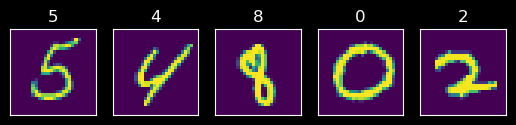

In [23]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)
        
plot_example(X_train, y_train)

[]

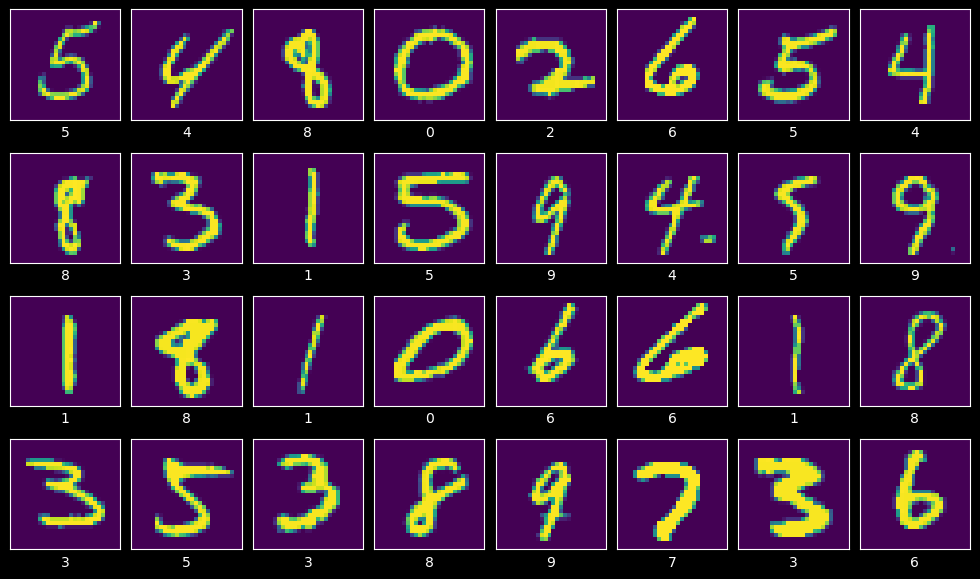

In [24]:
# Another version of plot

fig, ax = plt.subplots(4, 8, figsize=(12,7))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.1)

for i, ax in enumerate(ax.flatten()):
    plottable_image = np.reshape(X_train[i,:], (28, 28))
    ax.imshow(plottable_image)    
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.set(xticks=[], yticks=[],
            xlabel=y_train[i])
plt.plot()


### Premier ajustement des données avec un Linear SVC

On va ajuster le modèle et voir le score


In [25]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score

# Instantiation du classificateur et ajustement
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)

# Prediction à partir du fit
y_pred = lin_clf.predict(X_train)

/home/gsainton/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/gsainton/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [26]:
# Affichage du score 
accuracy_score(y_train, y_pred)

0.8696607142857142

### Amélioration

La première amélioration en général, c'est de normaliser les valeurs des images entre 0 et 1. Les images ici, sont entre 0 et 255
On utilise la fonction StandardScaler()
#### Normalisation des données

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

In [28]:
y_pred = lin_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.4328214285714286

In [29]:
svm_clf = SVC(gamma="scale")
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])

SVC()

In [30]:
y_pred = svm_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9474464285714286

#### Recherche RandomSearch avec Cross Validation


Il existe deux moyens de faire des recherches de paramètres : 

- `GridSearchCV` qui va consister à joueravec un jeu d'hyperamètres. Il va évaluer toutes les combinaisons possibles par validation croisée. 

- `RandomizedSearchCV` dont le fonctionnement est assez similaire à `GridSearchCV` mais qui choisi un certain nombre de combinaison prise au hasard. 


In [31]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

# Dans un premier temps, on essai sur 1000 données pour ne pas être trop gourmand 
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ..C=3.3535095282225447, gamma=0.0011323698903539594; total time=   0.1s
[CV] END ..C=3.3535095282225447, gamma=0.0011323698903539594; total time=   0.1s
[CV] END ..C=3.3535095282225447, gamma=0.0011323698903539594; total time=   0.1s
[CV] END ...C=1.5395306919515153, gamma=0.006294732756903124; total time=   0.2s
[CV] END ...C=1.5395306919515153, gamma=0.006294732756903124; total time=   0.2s
[CV] END ...C=1.5395306919515153, gamma=0.006294732756903124; total time=   0.2s
[CV] END ....C=2.932166021781022, gamma=0.003636128349646673; total time=   0.1s
[CV] END ....C=2.932166021781022, gamma=0.003636128349646673; total time=   0.1s
[CV] END ....C=2.932166021781022, gamma=0.003636128349646673; total time=   0.1s
[CV] END ...C=7.9106801154995425, gamma=0.012120445670174288; total time=   0.2s
[CV] END ...C=7.9106801154995425, gamma=0.012120445670174288; total time=   0.1s
[CV] END ...C=7.9106801154995425, gamma=0.012120

RandomizedSearchCV(cv=3, estimator=SVC(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fd90eb3b850>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fd90e979410>},
                   verbose=2)

In [32]:
rnd_search_cv.best_estimator_

SVC(C=3.3535095282225447, gamma=0.0011323698903539594)

In [33]:
rnd_search_cv.best_score_

0.8899887911863961

Je prends mon meilleur estimateur et je lui applique le fit de mes données d'entrainement

In [34]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

SVC(C=3.3535095282225447, gamma=0.0011323698903539594)

In [35]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9942857142857143

In [36]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.9684285714285714